## Lithology Prediction

### Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler


import os
import warnings
warnings.filterwarnings(action='ignore')
os.chdir('D:\Data analysis\Python\Python_sublessons\Drilling_models\Lithology_prediction')

### Displaying the first five rows of our data

In [2]:
data = pd.read_csv('./Realtime_Drilling_F_15.csv')

df = data.copy()

df.head()

,Depth,LAGMWT,Time,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,2013-11-28 12:54:29,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,2013-11-28 16:48:21,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,2013-11-28 17:01:59,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,2013-11-28 17:46:39,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,2013-11-28 18:02:50,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


In [3]:
df.columns

Index(['Depth', 'LAGMWT', 'Time', 'EditFlag', 'TORQUE', 'MOTOR_RPM',
       'STRATESUM', 'MWOUT', 'LAGMWDIFF', 'MWIN', 'BIT_RPM', 'DXC',
       'MUDRETDEPTH', 'PUMP', 'LAGMTEMP', 'RigActivityCode', 'MRIN', 'FLOWOUT',
       'ROP_AVG', 'LAGMRES', 'TOTGAS', 'MROUT', 'MTIN', 'LAGMRDIFF', 'FLOWIN',
       'WOB', 'ONBOTTOM_TIME', 'ECDBIT', 'MTOUT', 'BIT_DIST', 'SURF_RPM',
       'LAGMTDIFF', 'LITH'],
      dtype='object')

### Dropping the Time column as we don't need it for our Prediction model

In [4]:
df = df.drop(['Time'], axis = 1)

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


#### We can see that the data is clean and doesn't have any null values

<Axes: >

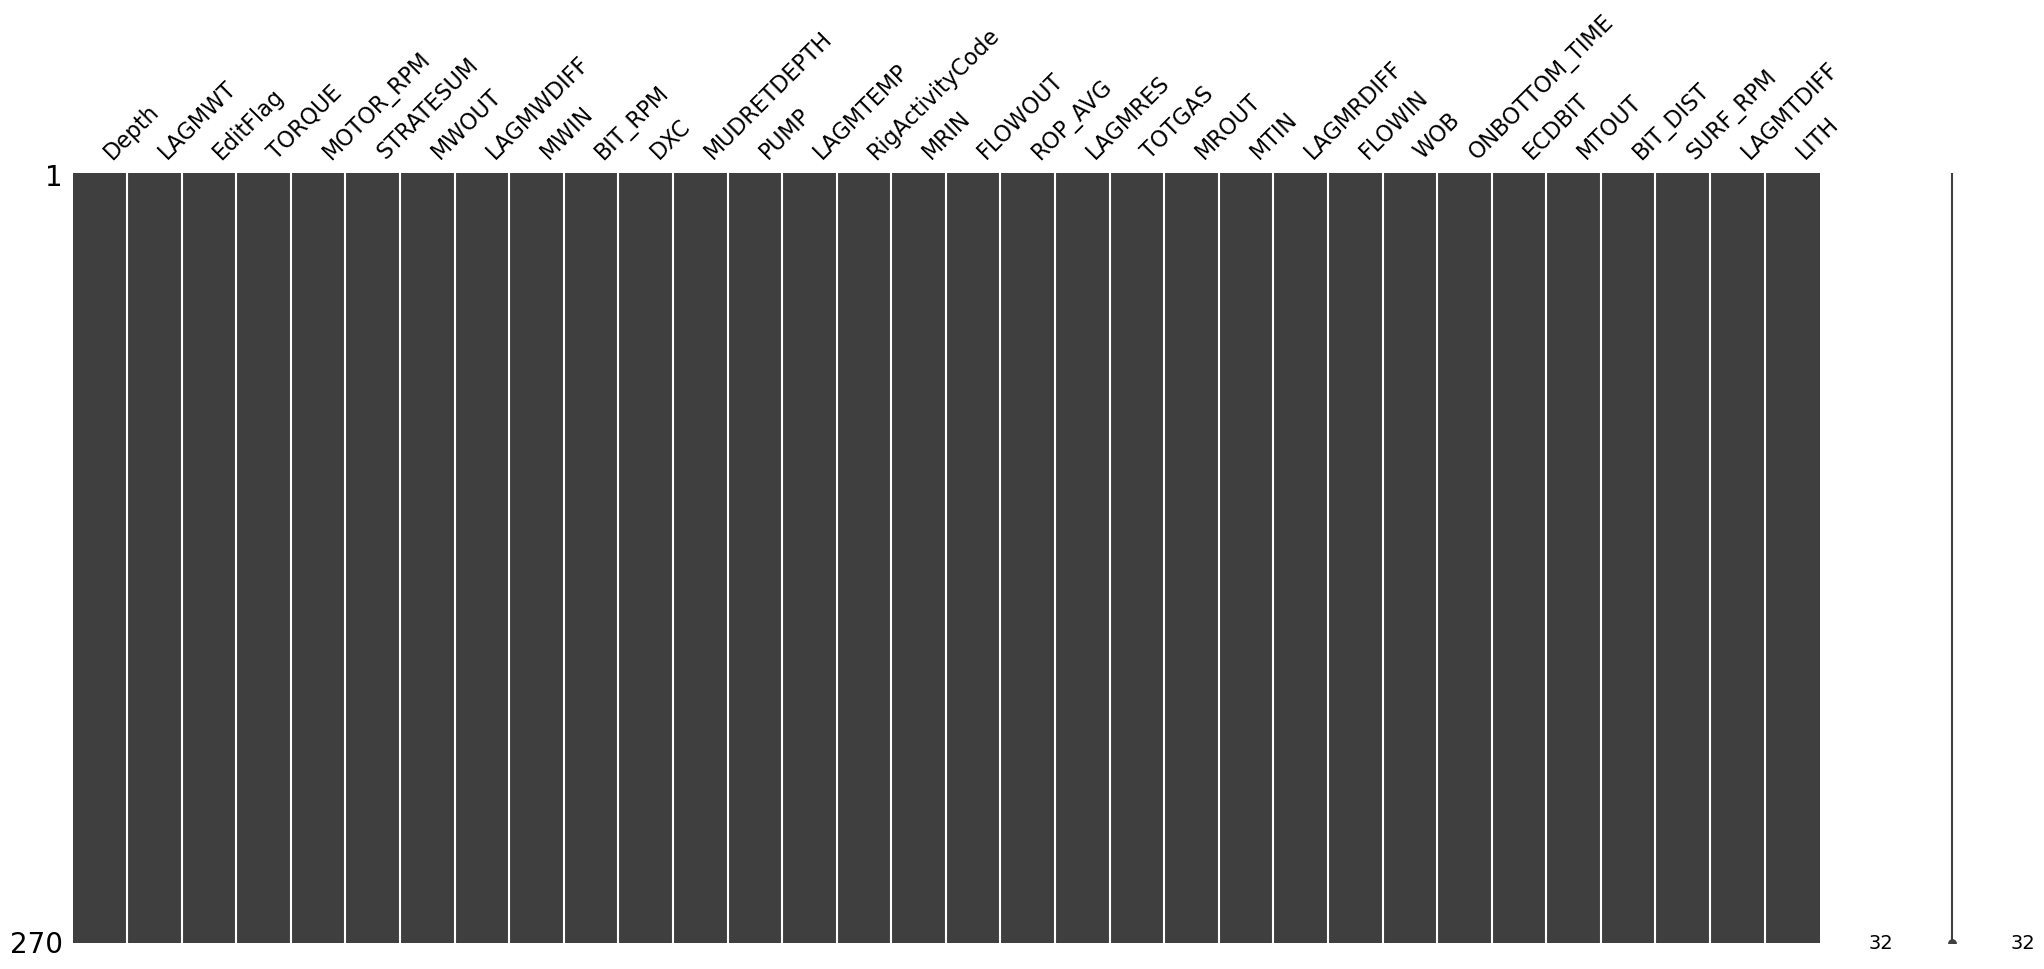

In [5]:
msno.matrix(df)

#### The counts of unique values of rock formations

In [6]:
df['LITH'].value_counts()

sandstone    219
marl          30
claystone     17
dolomite       3
limestone      1
Name: LITH, dtype: int64

### Dividing the Lithology column by the percentage of its' values

Text(0.5, 1.0, 'Lithology Classes Percentage')

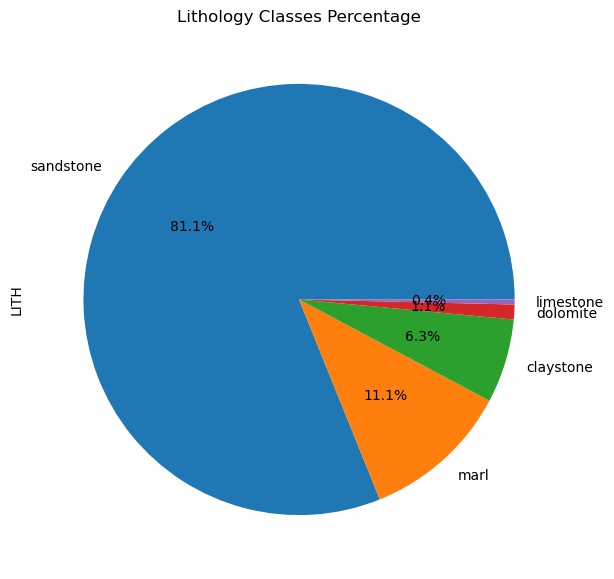

In [7]:
df.LITH.value_counts().plot(kind = 'pie', figsize = (7,7), autopct = '%1.1f%%', fontsize = 10)

plt.title('Lithology Classes Percentage')

#### Here we are looking at the chart that shows us Lithology classes ordered by their counts

##### We can clearly see that Sandstone is the most commonly encountered rock type in this formation

Text(0.5, 1.0, 'Lithology Classes')

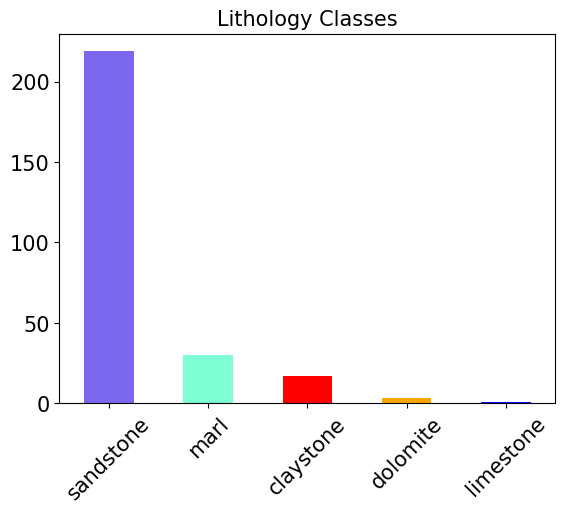

In [8]:
df.LITH.value_counts().plot(kind='bar', fontsize=15, rot=45,
                            color=['mediumslateblue', 'aquamarine', 'red', 'orange', 'blue'])

plt.title('Lithology Classes', size =15)

Due to the fact that there are very limited amounts of Limestone and Dolomite we will simply filter them out of an equation

In [9]:
df = df[(df['LITH']!='limestone') & (df['LITH']!='dolomite') ]

df.head()

,Depth,LAGMWT,EditFlag,TORQUE,MOTOR_RPM,STRATESUM,MWOUT,LAGMWDIFF,MWIN,BIT_RPM,...,LAGMRDIFF,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,MTOUT,BIT_DIST,SURF_RPM,LAGMTDIFF,LITH
0,3300.0,1280.0000,0.0,3768.1461,0.0,0.300773,1280.0000,0.000000,1280.0000,0.267094,...,0.0,0.006662,-19762.743,194.0,1293.6605,0.0,0.995211,0.267094,0.0,claystone
1,3305.0,1280.0000,0.0,20991.5430,0.0,1.674558,1306.2254,26.225434,1306.2254,1.314148,...,0.0,0.037091,26217.864,1617.0,1360.8740,0.0,5.995622,1.314720,0.0,marl
2,3310.0,1315.2258,0.0,22610.3830,0.0,1.766764,1320.0146,4.788793,1320.0146,1.328706,...,0.0,0.039134,83492.293,2435.0,1382.0713,0.0,10.997926,1.328674,0.0,marl
3,3315.0,1320.0008,0.0,24296.9810,0.0,1.768285,1320.0000,-0.000815,1320.0000,1.420887,...,0.0,0.039168,97087.882,3442.0,1381.7741,0.0,15.997564,1.420116,0.0,claystone
4,3320.0,1320.0000,0.0,24931.3130,0.0,1.783305,1320.0000,-0.000002,1320.0000,1.595948,...,0.0,0.039500,54793.206,4333.0,1381.5933,0.0,20.990649,1.593931,0.0,claystone


### Erroneous Features that have a lot of  inconsistent units, Sensor noise, outliers, data entry errors, calibration issues, etc.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Depth,266.0,3.977632e+03,3.895852e+02,3.300000e+03,3.646250e+03,3.977500e+03,4.313750e+03,4.645000e+03
LAGMWT,266.0,1.319681e+03,3.472684e+00,1.280000e+03,1.320000e+03,1.320000e+03,1.320000e+03,1.320001e+03
EditFlag,266.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
TORQUE,266.0,2.325276e+04,3.103327e+03,9.937208e+02,2.205334e+04,2.332076e+04,2.519823e+04,3.120819e+04
MOTOR_RPM,266.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
STRATESUM,266.0,1.771667e+00,1.684288e-01,9.412089e-03,1.783333e+00,1.799999e+00,1.800000e+00,1.816672e+00
MWOUT,266.0,1.319798e+03,2.590895e+00,1.280000e+03,1.320000e+03,1.320000e+03,1.320000e+03,1.320015e+03
LAGMWDIFF,266.0,1.165918e-01,1.633482e+00,-8.154203e-04,0.000000e+00,0.000000e+00,0.000000e+00,2.622543e+01
MWIN,266.0,1.319798e+03,2.590895e+00,1.280000e+03,1.320000e+03,1.320000e+03,1.320000e+03,1.320015e+03
BIT_RPM,266.0,2.259363e+00,4.132335e-01,1.055489e-02,1.999417e+00,2.068660e+00,2.663961e+00,3.000916e+00


In [11]:
erroneous_features = ['RigActivityCode', 'DXC', 'MWIN', 'LAGMTDIFF', 'WOB']

## Suppress scientific notation, which means the number is written in a standart decimal format
summary_stats_erroneous = df[erroneous_features].describe().round(2) 

summary_stats_erroneous

,RigActivityCode,DXC,MWIN,LAGMTDIFF,WOB
count,266.0,266.00,266.00,266.00,266.00
mean,111.0,0.99,1319.80,-286.16,57460.18
std,0.0,0.00,2.59,69.65,122318.81
min,111.0,0.99,1280.00,-303.15,-43003.60
25%,111.0,0.99,1320.00,-303.15,37032.77
50%,111.0,0.99,1320.00,-303.15,45629.43
75%,111.0,0.99,1320.00,-303.15,55076.90
max,111.0,0.99,1320.01,0.00,1857840.10


count    266.000000
mean    -286.157987
std       69.647782
min     -303.150000
25%     -303.150000
50%     -303.150000
75%     -303.150000
max        0.000000
Name: LAGMTDIFF, dtype: float64
[   0.        -28.071857 -302.4528   -303.1499   -303.15    ]


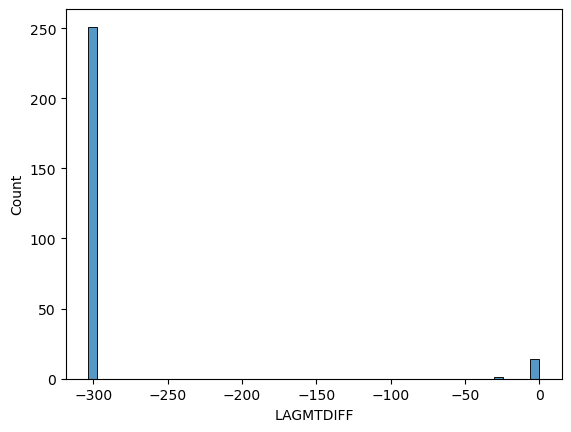

In [12]:
erroneous_feature = 'LAGMTDIFF'

print(df[erroneous_feature].describe())
print(df[erroneous_feature].unique())

sns.histplot(df[erroneous_feature], bins = 50)

# plt.xlim(0,0.2)
# plt.ylim(ymax=20)
plt.show()

This line of code can help to identify columns that predominantly consist of zeros. And in return indicate the low importance value of a feature

In [13]:
## Calculate the proportion of zeros in each feature
for col in df.columns:
    sum_zeros = (df[col]==0).sum()
    pct_zeros = sum_zeros/len(df)*100
    print(f'{col}:{pct_zeros:.0f}%')

Depth:0%
LAGMWT:0%
EditFlag:100%
TORQUE:0%
MOTOR_RPM:100%
STRATESUM:0%
MWOUT:0%
LAGMWDIFF:81%
MWIN:0%
BIT_RPM:0%
DXC:0%
MUDRETDEPTH:0%
PUMP:0%
LAGMTEMP:5%
RigActivityCode:0%
MRIN:100%
FLOWOUT:0%
ROP_AVG:0%
LAGMRES:100%
TOTGAS:0%
MROUT:100%
MTIN:4%
LAGMRDIFF:100%
FLOWIN:0%
WOB:0%
ONBOTTOM_TIME:0%
ECDBIT:0%
MTOUT:100%
BIT_DIST:0%
SURF_RPM:0%
LAGMTDIFF:5%
LITH:0%


#### Erroneous features summary:

- MOTOR_RPM, MTOUT, MROUT, MRIN, LAGMRES, LAGMRDIFF, and EditFlag have all zeros
- DXC and RigActivityCode have all same values, 0.98767 and 111, respectively
- MWIN, LAGMTEMP, MTIN, MWOUT, LAGMTDIFF, and LAGMWT have all percentiles and maximum value similar
- LAGMWDIFF has 80% zero values and very large maximum value (outlier)
- WOB has negative minimum value (which can't be true) and very large maximum value (outlier)

All these erroneus features won't be used in our prediction, except for WOB, we can remove the outliers and still use it.

In [14]:
## We are simply dropping the features that will not play any role in making a prediction due to them being filled with zeros
# Or having an unusual distribution of min and max values

erroneous_fetures = ['MOTOR_RPM', 'MTOUT', 'MROUT', 'MRIN', 'LAGMRES', 'LAGMRDIFF', 
                    'EditFlag', 'DXC', 'RigActivityCode', 'LAGMWT', 'MWIN', 
                    'LAGMTEMP', 'MTIN', 'MWOUT', 'LAGMTDIFF', 'LAGMWDIFF']

df = df.drop(erroneous_fetures, axis = 1)

## Manually removing outliers from WOB to use it in a future model creation

df = df[(df['WOB']>0) & (df['WOB']<1e6)].reset_index(drop = True)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,MUDRETDEPTH,PUMP,FLOWOUT,ROP_AVG,TOTGAS,FLOWIN,WOB,ONBOTTOM_TIME,ECDBIT,BIT_DIST,SURF_RPM,LITH
0,3305.0,20991.543,1.674558,1.314148,3301.7245,17932214.0,0.038981,0.004088,0.000183,0.037091,26217.864,1617.0,1360.8740,5.995622,1.314720,marl
1,3310.0,22610.383,1.766764,1.328706,3301.7245,20878002.0,0.041079,0.005159,0.000176,0.039134,83492.293,2435.0,1382.0713,10.997926,1.328674,marl
2,3315.0,24296.981,1.768285,1.420887,3302.8926,20728354.0,0.041359,0.005971,0.000188,0.039168,97087.882,3442.0,1381.7741,15.997564,1.420116,claystone
3,3320.0,24931.313,1.783305,1.595948,3306.1559,20553813.0,0.043607,0.005419,0.000276,0.039500,54793.206,4333.0,1381.5933,20.990649,1.593931,claystone
4,3325.0,24330.264,1.783333,1.653237,3311.3763,20492430.0,0.043191,0.005435,0.000253,0.039501,50301.579,5255.0,1381.1635,25.996929,1.653262,marl


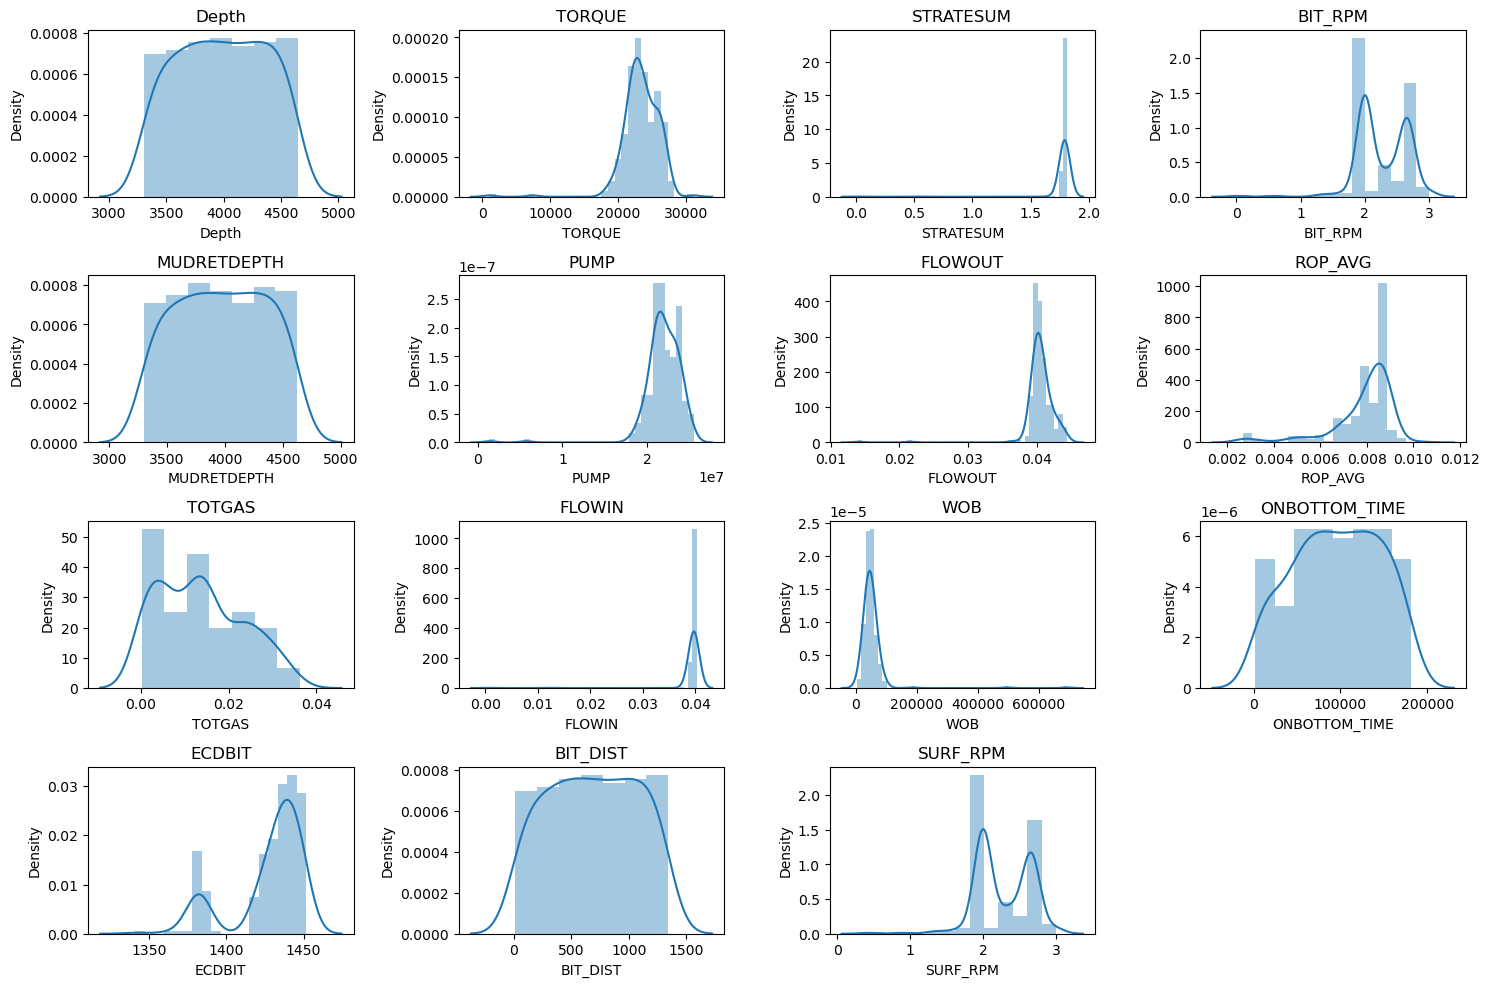

In [15]:
# This code is useful for visually examining the distributions of different features in the DataFrame.
## Which can help identify potential patterns, outliers, or relationships between variables.

features = df.columns[:-1]


plt.figure(figsize=(15,12))
for i in range(len(features)):
    plt.subplot(5, 4, i+1)
    sns.distplot(df[features[i]],kde = True)
    plt.title(features[i])
plt.tight_layout()
plt.show()

In [16]:
def corr_heatmap(df):
# Generate a mask for the upper triangle
# Generates a boolean mask of the same shape as the correlation matrix of the DataFrame.
# The mask is initially filled with False values.
    mask = np.zeros_like(df.corr(method = 'spearman'), dtype=np.bool_)
    
# This sets the upper triangle of the mask to True, 
# creating a mask that covers the upper triangular portion of the correlation matrix.
# This is done to hide the redundant information (symmetrical correlations) and improve readability in the heatmap.
    mask[np.triu_indices_from(mask)]=True
    
    # Generating a diverging colormap
# This line generates a diverging colormap using seaborn's cubehelix_palette function.
# The colormap has 12 colors and starts at a light shade (-2.25) and rotates (-1.3) to create an appealing color gradient.
# However, this line is overridden by the subsequent lines that redefine the cmap variable.
    cmap = sns.cubehelix_palette(n_colors=12,start=-2.25, rot=-1.3, as_cmap=True)
    cmap = 'PRGn'
    cmap = 'plasma'
    
    # Drawing the heatmap with the mask and correct aspect ratio
    
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(method = 'spearman'), annot=True, mask=mask,cmap=cmap, 
               vmin=0, vmax=1, square=True)
    
    plt.show()

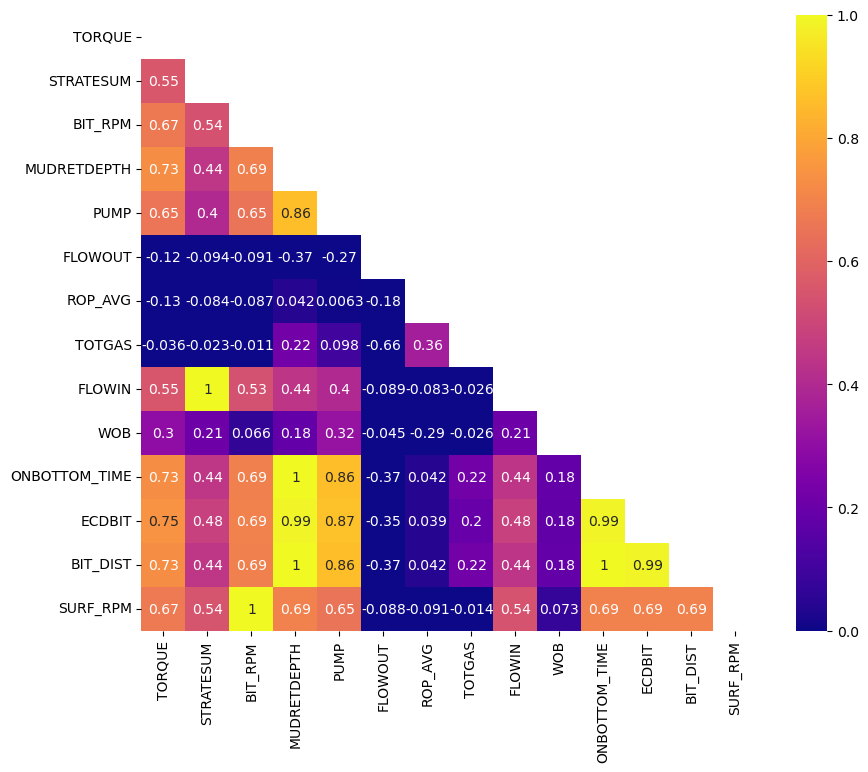

In [17]:
## All features except Depth

no_depth = df.columns[1:]

# Plot correlation heatmap

corr_heatmap(df[no_depth])

In [18]:
# Remove correlated features because there is no need for features with correlation equal 1
# Which means they are practically the same

correlated_features = ['MUDRETDEPTH', 'BIT_DIST', 'ONBOTTOM_TIME', 'SURF_RPM', 'FLOWIN']

df = df.drop(correlated_features, axis = 1)

df.head()

,Depth,TORQUE,STRATESUM,BIT_RPM,PUMP,FLOWOUT,ROP_AVG,TOTGAS,WOB,ECDBIT,LITH
0,3305.0,20991.543,1.674558,1.314148,17932214.0,0.038981,0.004088,0.000183,26217.864,1360.8740,marl
1,3310.0,22610.383,1.766764,1.328706,20878002.0,0.041079,0.005159,0.000176,83492.293,1382.0713,marl
2,3315.0,24296.981,1.768285,1.420887,20728354.0,0.041359,0.005971,0.000188,97087.882,1381.7741,claystone
3,3320.0,24931.313,1.783305,1.595948,20553813.0,0.043607,0.005419,0.000276,54793.206,1381.5933,claystone
4,3325.0,24330.264,1.783333,1.653237,20492430.0,0.043191,0.005435,0.000253,50301.579,1381.1635,marl


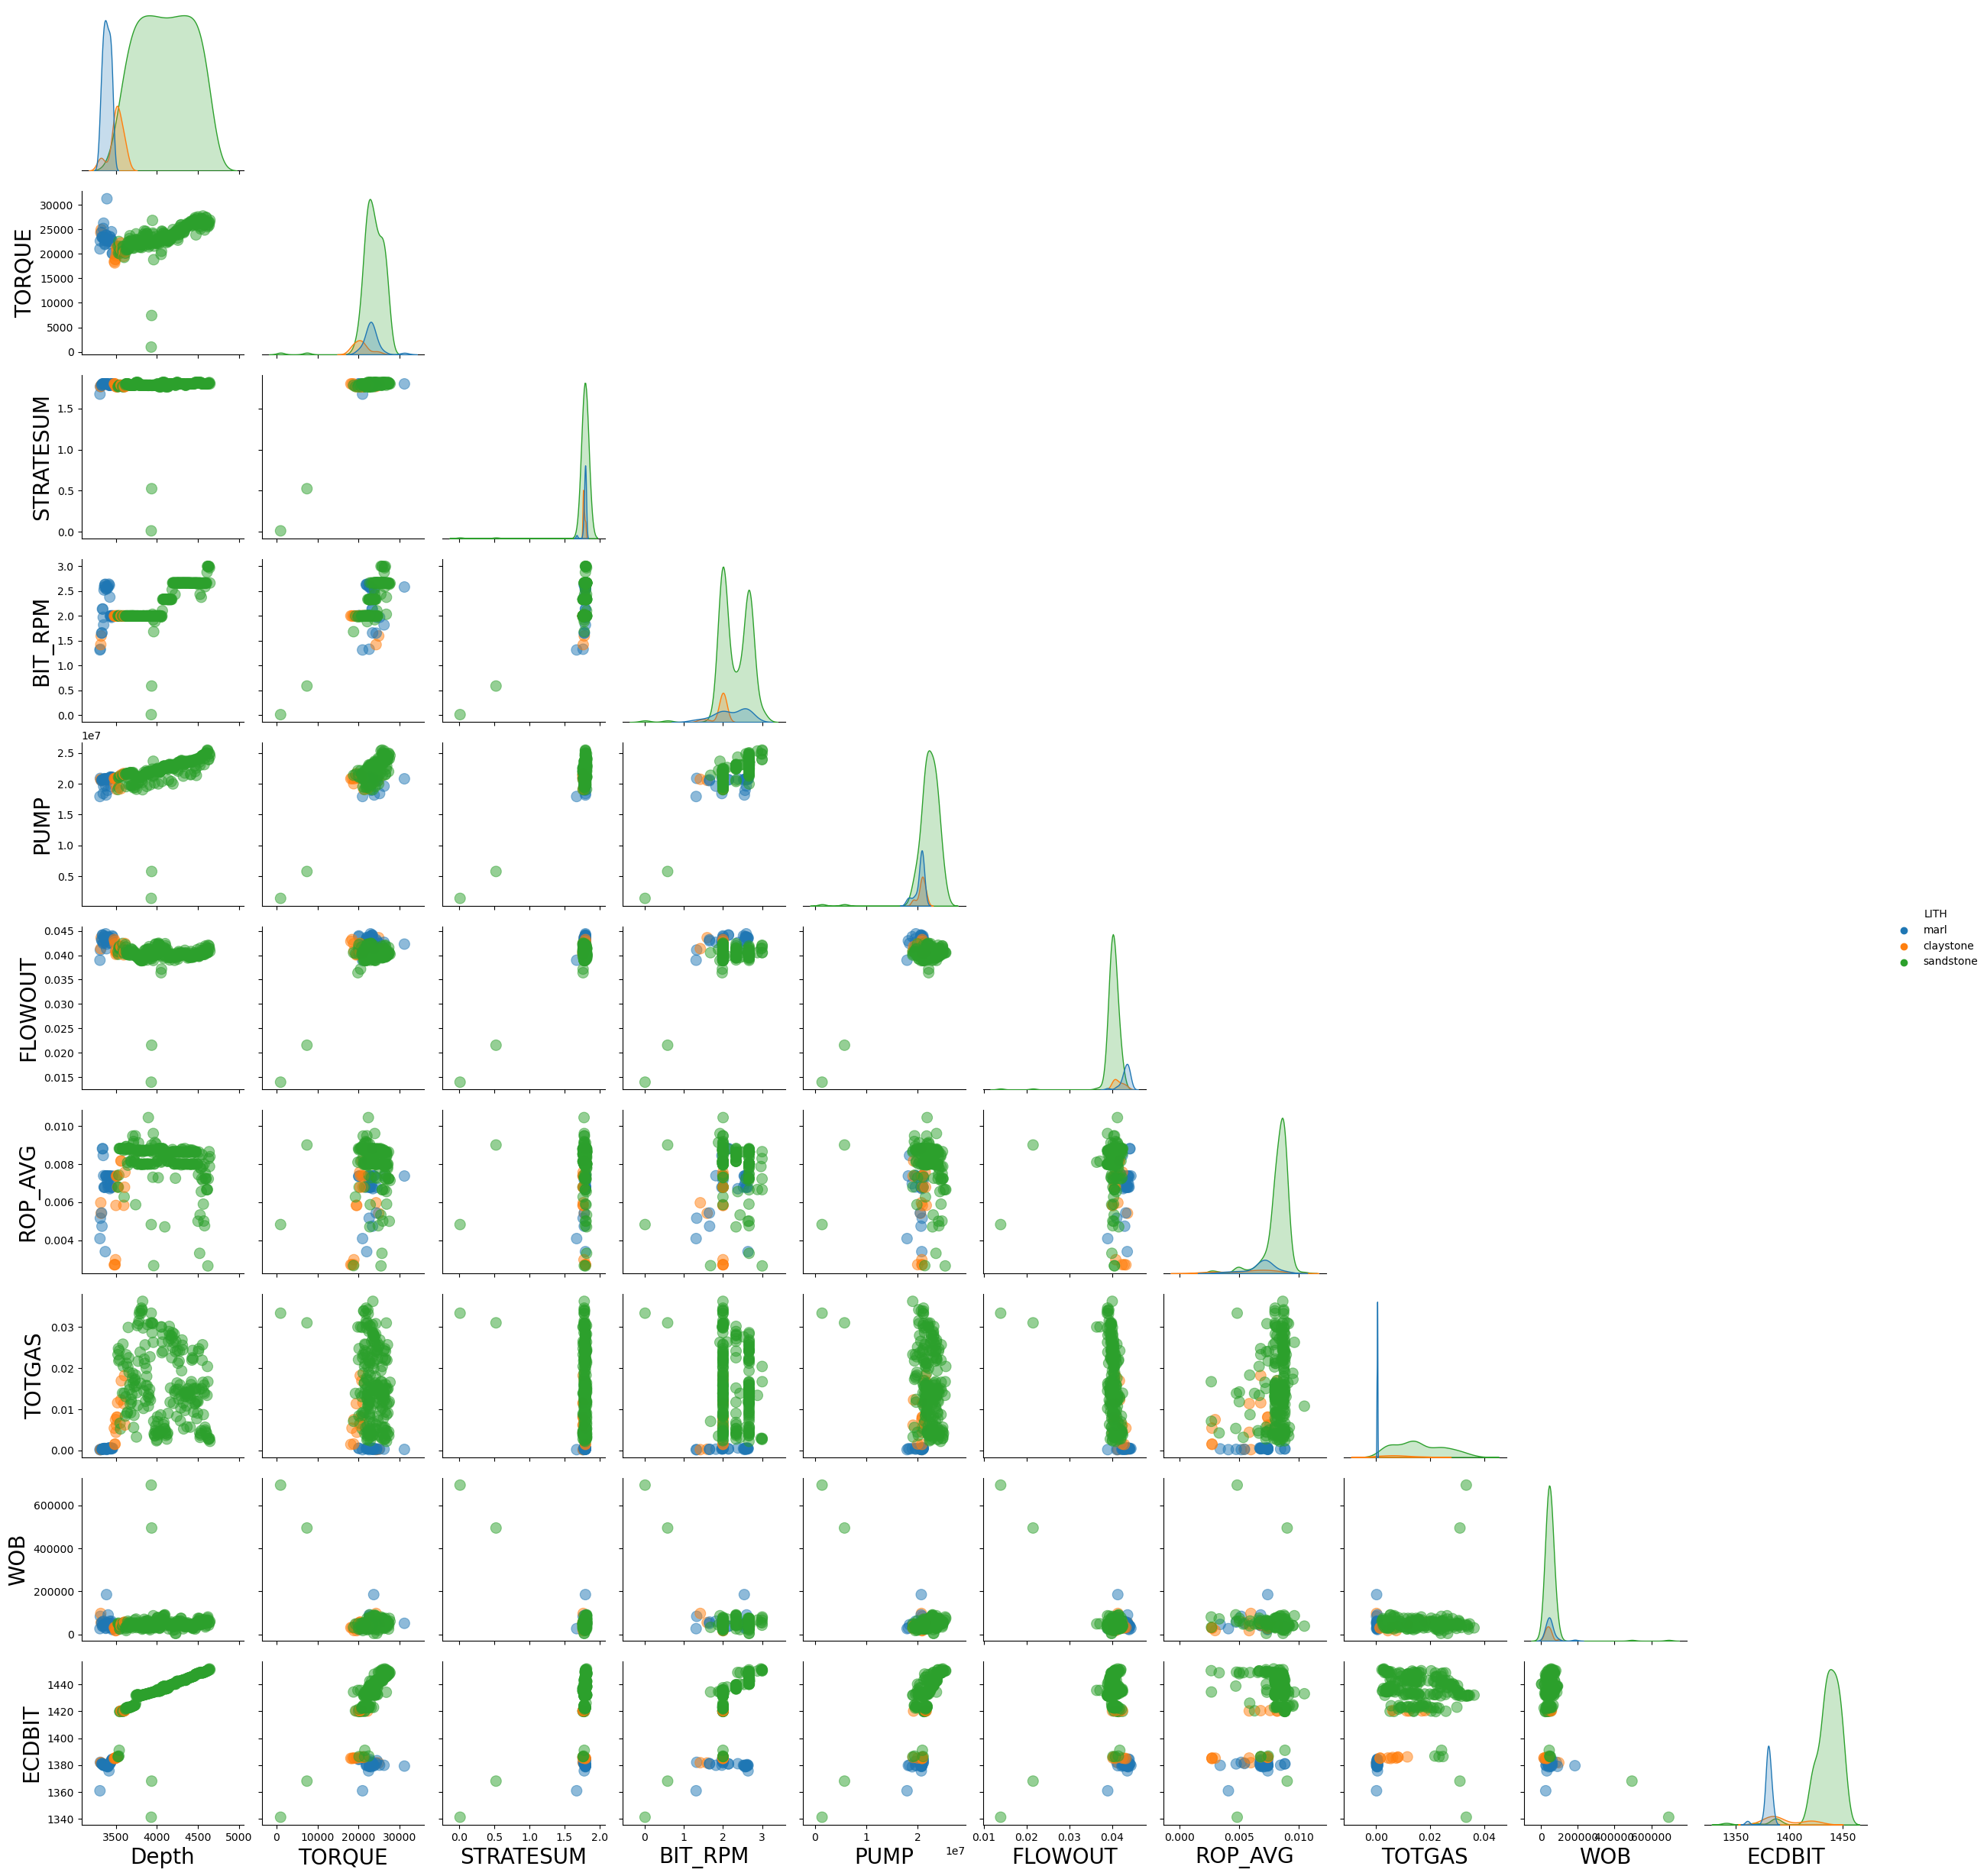

In [19]:
# Plot pairplot

# The labels on the x-axis and y-axis will be displayed with a font size of 20 by default
plt.rcParams['axes.labelsize'] = 20

g = sns.pairplot(data = df, hue = 'LITH', corner=True, 
            plot_kws={'alpha':0.5, 's':100, 'edgecolor':None})

## Log Display

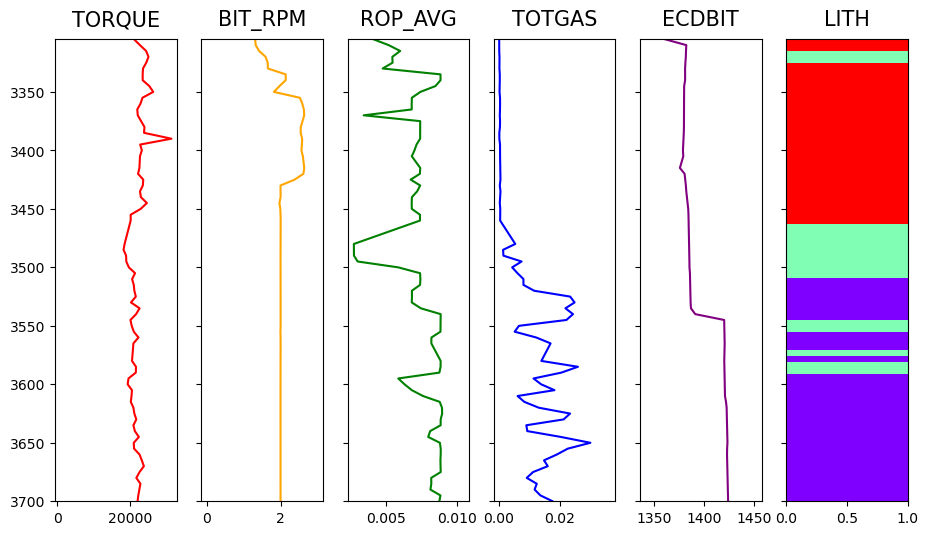

In [20]:
# These variables represent the number of rows and columns in the subplot grid.

rows, cols = 1,6

# Enables sharing the y-axis among all subplots (sharey=True)
figs, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (11,6), sharey=True)
features = ['TORQUE', 'BIT_RPM', 'ROP_AVG', 'TOTGAS', 'ECDBIT']
colors = ['red', 'orange', 'green', 'blue', 'purple']

## Encoding Lithology
lith = df.LITH.values
lith_code = []

for i in range(len(lith)):
    if lith[i]=='sandstone':
        code = 1
    if lith[i]=='claystone':
        code = 2
    if lith[i]=='marl':
        code = 3
    lith_code.append(code)
    
F = np.vstack((lith_code, lith_code)).T

for i in range(cols):
    if i < cols-1:
        ax[i].plot(df[features[i]], df['Depth'], color= colors[i])
        ax[i].set_ylim(max(df['Depth']), min(df['Depth']))
        ax[i].set_title(features[i], size =15, pad = 10)
    elif i==cols-1:
        ax[i].imshow(F,aspect = 'auto', extent = [0,1,max(df['Depth']), min(df['Depth'])], cmap = 'rainbow')
        ax[i].set_title('LITH', size = 15, pad =10)
        
plt.ylim(ymin = 3700);

## Train-test split, oversampling with RandomOverSampler, cross-validation, then prediction

In [21]:
# Drop Depth column and separate the feature and target columns
X= df.drop(['LITH'], axis = 1)
y = df['LITH']

# Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.35)

# Defining over sampling
over = RandomOverSampler()

# Defining model
model = AdaBoostClassifier()
# Defining Normalization
norm = StandardScaler()

#Putting it all into a Pipeline
steps = [('norm', norm), ('o', over),('model', model)]
pipe = Pipeline(steps=steps)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=10)

scores_pipe = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv)


## Oversampling test data

over = RandomOverSampler()
X_test, y_test = over.fit_resample(X_test, y_test)

# GradientBoostingClassifer Model

In [22]:
# Drop Depth column and separate the feature and target columns
X= df.drop(['LITH'], axis = 1)
y = df['LITH']

# Train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.35)

# Defining over sampling
over = RandomOverSampler()

# Defining model
model = GradientBoostingClassifier()
# Defining Normalization
norm = StandardScaler()

#Putting it all into a Pipeline
steps = [('norm', norm), ('o', over),('model', model)]
pipe = Pipeline(steps=steps)

scoring = ['accuracy', 'precision_macro', 'recall_macro']
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=10)

scores_pipe = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=cv)


## Oversampling test data

over = RandomOverSampler()
X_test, y_test = over.fit_resample(X_test, y_test)

In [23]:
## Summarize performance 

print('Mean Accuracy: %.4f%%'% np.mean(scores_pipe['test_accuracy']))
print('Mean Precision: %.4f%%'% np.mean(scores_pipe['test_precision_macro']))
print('Mean Recall: %.4f%%'% np.mean(scores_pipe['test_recall_macro']))

Mean Accuracy: 0.9725%
Mean Precision: 0.8507%
Mean Recall: 0.8770%


In [24]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   claystone       0.84      0.70      0.76        76
        marl       0.84      0.91      0.87        76
   sandstone       0.88      0.96      0.92        76

    accuracy                           0.86       228
   macro avg       0.85      0.86      0.85       228
weighted avg       0.85      0.86      0.85       228



In [26]:
from sklearn.metrics import ConfusionMatrixDisplay

<Figure size 800x600 with 0 Axes>

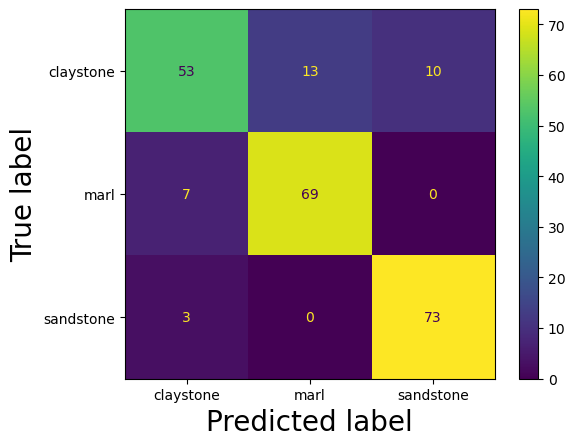

In [27]:
plt.figure(figsize=(8,6))

con_m = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(con_m, display_labels = pipe.classes_)
disp.plot()

plt.show();

## Feature Importance

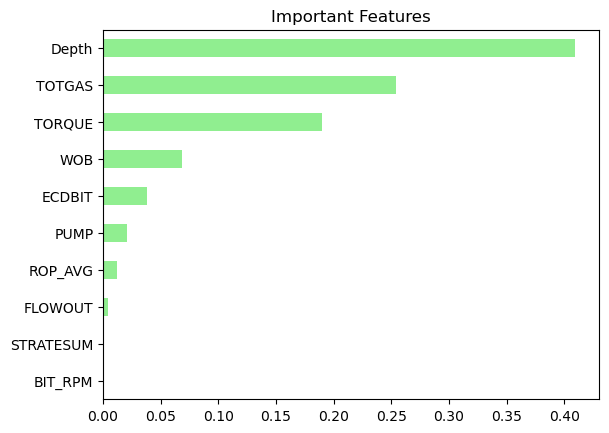

In [28]:
feature_importance = pipe.steps[2][1].feature_importances_

# Creating a pd.Series for feature importances

importances = pd.Series(data=feature_importance,
         index=X_train.columns)

# Sorting importances 

importances = importances.sort_values(ascending=True)

# Draw a horizontal barplot of sorted importances

importances.plot(kind = 'barh',color = 'lightgreen')
plt.title('Important Features')

plt.show()

### Roc_Auc score as the model performance evaluation metric

In [30]:
roc_auc_score(y_test,y_pred_proba,average='weighted',multi_class='ovr')

0.9725300092336104

### Generating class membership probabilities

In [29]:
y_pred_proba = pipe.predict_proba(X_test)


# Example prediction for observation no 10

no_obs =10

classes = ['claystone', 'marl', 'sandstone']
for i in range(len(classes)):
    print(f'{classes[i]}: {y_pred_proba[no_obs-1][i]: .3f}')

claystone:  0.000
marl:  0.000
sandstone:  1.000
